# **AdIrassa Online 🎓**

The following is the notebook used to train the agents created for the **AIdirassa Online** platform,
which is a multi-agent powered platform designed to create a learning pathway that is 100% generated by AI,
including assessments, course pathways, topics, exercises, quizzes, and much more.

## Workflow

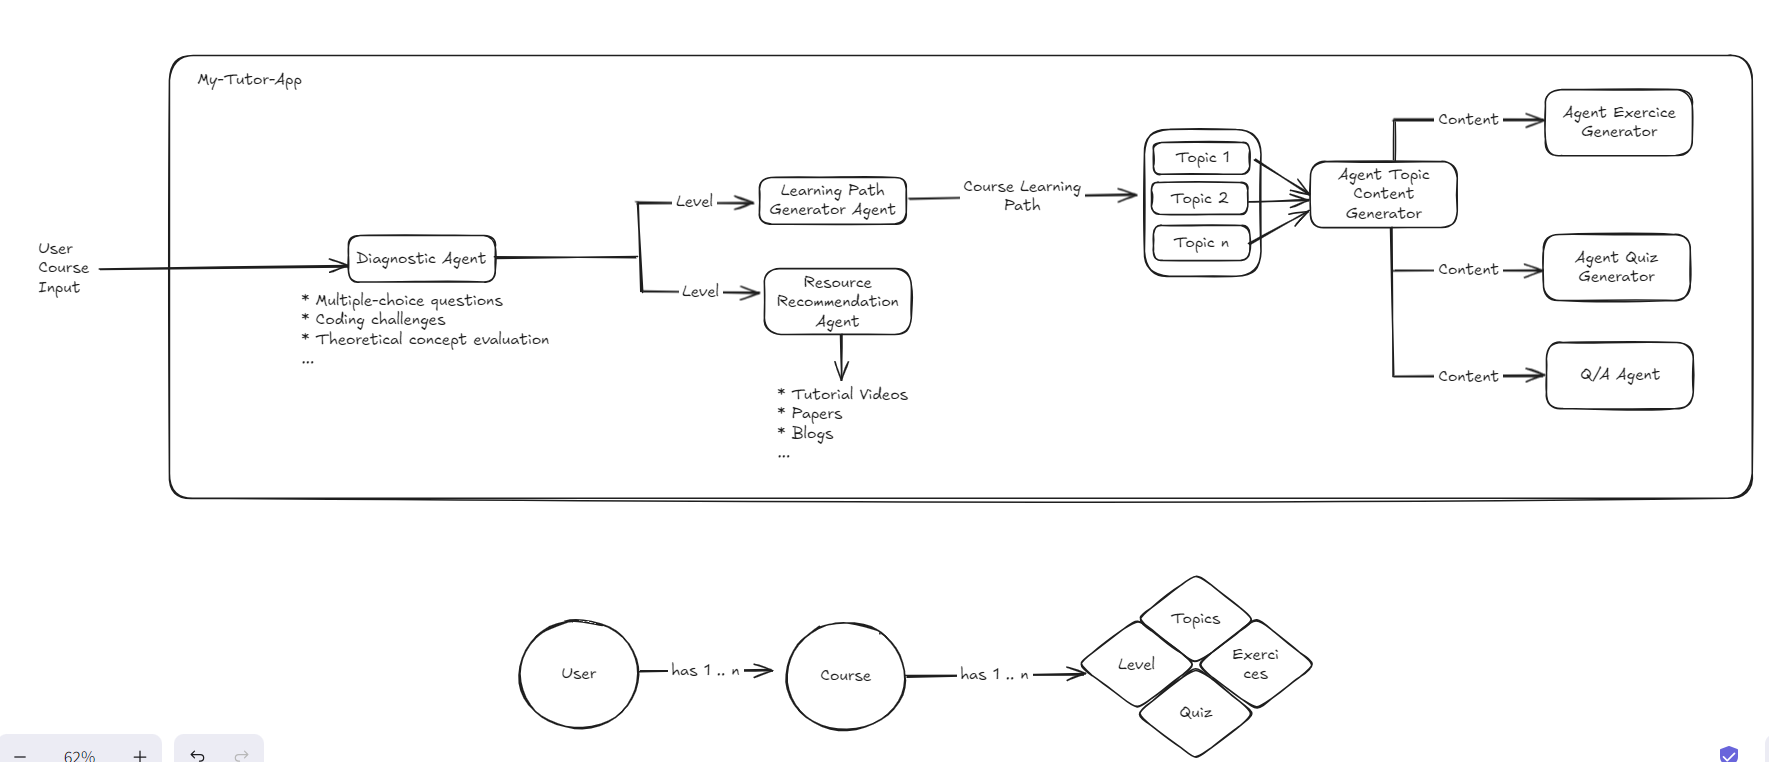

To make this easier to understand, we will use the following use case.

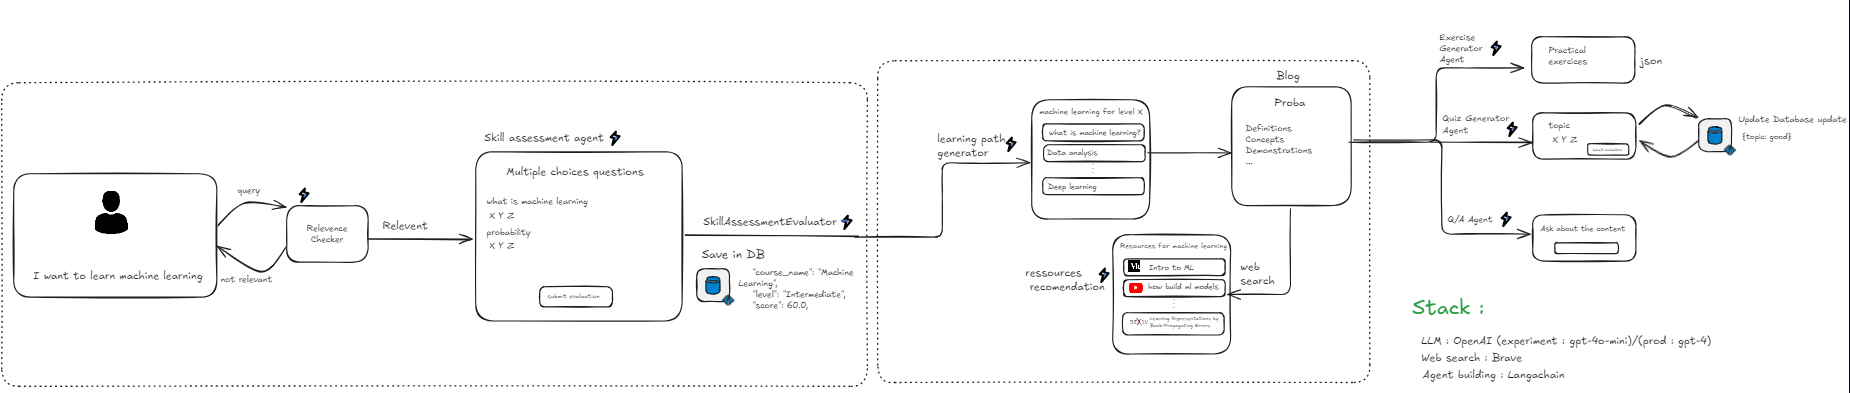

## Required libreries and frameworks

In [ ]:
!pip install -Uq langchain_community langchain-openai langchain_experimental tavily-python

importing all the modules

In [ ]:
from google.colab import userdata
from pydantic import BaseModel, Field
from typing import List, Type , Dict,Union
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.runnables import Runnable
from langchain_openai import ChatOpenAI
import os
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.chains import RetrievalQAWithSourcesChain
from langchain.schema import Document
from enum import Enum
import json
from typing import List, Union
from langchain_community.tools import BraveSearch

In [ ]:
def _set_env(var: str):
    if not os.environ.get(var):
        try:
            os.environ[var] = userdata.get(f"{var}")
        except Exception as e:
            print(f"Error setting environment variable {var}: {e}")
            print(f"Please set {var} manually.")


_set_env("OPENAI_API_KEY")

In [ ]:
openai_api_key = os.environ.get("OPENAI_API_KEY")

In [ ]:
# Initialize the model
model = ChatOpenAI(model_name="gpt-4o-mini")

## Diagnostic phase

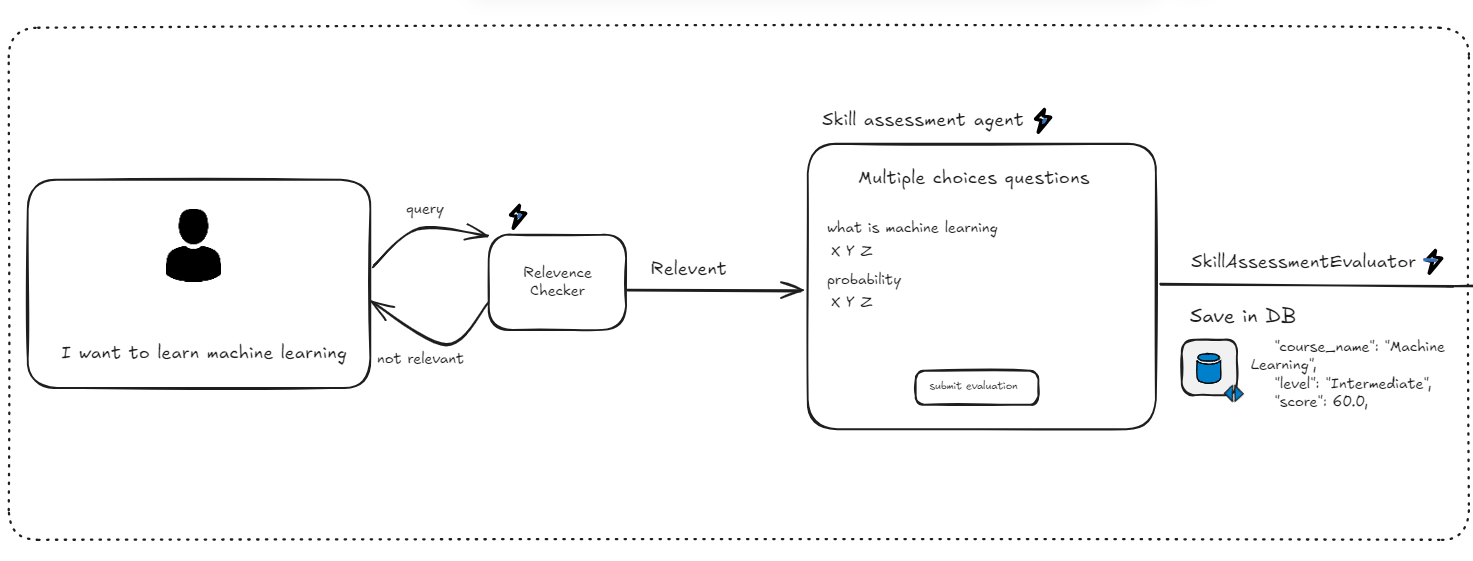

### Agent to check relevence

This agent is used to intercept the user query to check its relevance and determine whether to proceed to the next step.

In [ ]:
context_check_prompt = """
You are an AI designed to classify user inputs as relevant or not relevant to educational skill extraction and learning-related tasks.
### Task:
1. Analyze the user's input.
2. Determine whether it is relevant to learning, skill development, or educational contexts.
3. Return "Relevant" or "Not Relevant".
### Input:
User Input: [User Input]
### Output:
Return a single string: "Relevant" or "Not Relevant".
"""

In [ ]:
user_input = "I'm eating apple"

In [ ]:
prompt_template = ChatPromptTemplate.from_messages([
    ("system", context_check_prompt),
    ("user", "{user_input}")
])

In [ ]:
# Create and run the chain
chain = prompt_template | model

# Execute the chain
response = chain.invoke({"user_input": user_input})

print(f"Relevance Check Result: {response.content}")

Relevance Check Result: Not Relevant


In [ ]:
user_input = "I'm learning machine"

In [ ]:
# Create and run the chain
chain = prompt_template | model

# Execute the chain
response = chain.invoke({"user_input": user_input})

print(f"Relevance Check Result: {response.content}")

Relevance Check Result: Relevant


### Agent to create skill assessment


In [ ]:
# Define Data Models
class MCQQuestion(BaseModel):
    question_text: str = Field(description="MCQ question text")
    options: List[str] = Field(description="List of answer options", min_items=4, max_items=4)
    correct_answer: str = Field(description="Correct option label (e.g., 'A', 'B', 'C', 'D')")

class SubSkill(BaseModel):
    related_skill_name: str = Field(description="Name of the related skill")
    mcq_questions: List[MCQQuestion] = Field(description="List of MCQ questions for this related skill")

class Skill(BaseModel):
    main_skill: str = Field(description="Name of the main skill")
    related_skills: List[SubSkill] = Field(description="List of related skills and their MCQ questions")

In [ ]:
class SkillAssessmentAgent:
    def __init__(self, model):
        self.model = model
        self.parser = PydanticOutputParser(pydantic_object=Skill)

        # Fix: Escape curly braces in the JSON example and handle format_instructions
        self.system_prompt = '''
You are a skill assessment generator. Given a text input, identify the main skill and 5 related skills.
For each related skill, generate 3 MCQ questions with 4 options each and indicate the correct answer.
Your response should be a JSON object conforming to the following structure:

{{
  "main_skill": "Main Skill Name",
  "related_skills": [
    {{
      "related_skill_name": "related-skill Name",
      "mcq_questions": [
        {{
          "question_text": "Question text",
          "options": ["Option A", "Option B", "Option C", "Option D"],
          "correct_answer": "A"
        }},
        ...
      ]
    }},
    ...
  ]
}}

{format_instructions}
'''

        # Generate the correct format instructions using the parser
        format_instructions = self.parser.get_format_instructions()

        self.template = ChatPromptTemplate.from_messages([
            ("system", self.system_prompt),
            ("human", "Generate skills and MCQ questions based on the following text: {input_text}")
        ])

        self.chain = self.template | self.model | self.parser

    def generate_skill_assessment(self, input_text: str) -> Skill:
        try:
            # Pass format_instructions along with input_text
            skill_assessment = self.chain.invoke({
                "input_text": input_text,
                "format_instructions": self.parser.get_format_instructions()
            })
            return skill_assessment
        except Exception as e:
            print(f"Error generating skill assessment: {e}")
            return None


In [ ]:
# Example Usage
skill_agent = SkillAssessmentAgent(model)
input_text = "I want to learn machine learning "
skill_output = skill_agent.generate_skill_assessment(input_text)

if skill_output:
    print(f"Main Skill: {skill_output.main_skill}")
    for subskill in skill_output.related_skills:
        print(f"\nSub-skill: {subskill.related_skill_name}")
        for idx, question in enumerate(subskill.mcq_questions, start=1):
            print(f"\nQuestion {idx}:")
            print(f" {question.question_text}")
            for i, option in enumerate(question.options, start=65):  # Options start from 'A'
                print(f" {chr(i)}. {option}")
            print(f" Correct Answer: {question.correct_answer}")

Main Skill: Machine Learning

Sub-skill: Data Preprocessing

Question 1:
 What is the purpose of data preprocessing in machine learning?
 A. To clean and transform raw data
 B. To visualize data
 C. To build models
 D. To evaluate performance
 Correct Answer: A

Question 2:
 Which technique is commonly used for handling missing data?
 A. Normalization
 B. Imputation
 C. Encoding
 D. Splitting
 Correct Answer: B

Question 3:
 What does normalization do?
 A. Reduces overfitting
 B. Converts categorical data to numerical
 C. Scales features to a specific range
 D. Improves model accuracy
 Correct Answer: C

Sub-skill: Model Selection

Question 1:
 Which of the following is a common metric for evaluating classification models?
 A. Mean Squared Error
 B. Accuracy
 C. R-squared
 D. Variance
 Correct Answer: B

Question 2:
 What is cross-validation used for?
 A. To split data into training and testing sets
 B. To improve data preprocessing
 C. To assess model performance
 D. To increase data 

In [ ]:
skill_output

Skill(main_skill='Machine Learning', related_skills=[SubSkill(related_skill_name='Data Preprocessing', mcq_questions=[MCQQuestion(question_text='What is the purpose of data preprocessing in machine learning?', options=['To clean and transform raw data', 'To visualize data', 'To build models', 'To evaluate performance'], correct_answer='A'), MCQQuestion(question_text='Which technique is commonly used for handling missing data?', options=['Normalization', 'Imputation', 'Encoding', 'Splitting'], correct_answer='B'), MCQQuestion(question_text='What does normalization do?', options=['Reduces overfitting', 'Converts categorical data to numerical', 'Scales features to a specific range', 'Improves model accuracy'], correct_answer='C')]), SubSkill(related_skill_name='Model Selection', mcq_questions=[MCQQuestion(question_text='Which of the following is a common metric for evaluating classification models?', options=['Mean Squared Error', 'Accuracy', 'R-squared', 'Variance'], correct_answer='B'),

### SkillAssessmentEvaluator agent

In [ ]:
class PerformanceLevel(str, Enum):
    BEGINNER = "Beginner"
    INTERMEDIATE = "Intermediate"
    ADVANCED = "Advanced"
    EXPERT = "Expert"

class SkillScore(BaseModel):
    name: str
    score: float

class DetailedEvaluation(BaseModel):
    course_name: str
    level: PerformanceLevel
    score: float
    weaknesses: List[SkillScore]
    strengths: List[SkillScore]

class SkillAssessmentEvaluator:
    def __init__(self):
        self.level_thresholds = {
            (0, 50): PerformanceLevel.BEGINNER,
            (50, 75): PerformanceLevel.INTERMEDIATE,
            (75, 90): PerformanceLevel.ADVANCED,
            (90, 101): PerformanceLevel.EXPERT
        }

    def evaluate(self, skill_data: 'Skill', user_answers: List[str]) -> DetailedEvaluation:
        question_index = 0
        skill_results = {}

        for related_skill in skill_data.related_skills:
            skill_name = related_skill.related_skill_name
            correct_count = 0
            answers = []

            for question in related_skill.mcq_questions:
                user_answer = user_answers[question_index]
                is_correct = user_answer == question.correct_answer
                correct_count += 1 if is_correct else 0
                answers.append(is_correct)
                question_index += 1

            skill_score = (correct_count / len(related_skill.mcq_questions)) * 100
            skill_results[skill_name] = skill_score

        overall_score = sum(skill_results.values()) / len(skill_results)

        strengths = [SkillScore(name=k, score=v) for k, v in skill_results.items() if v >= 70]
        weaknesses = [SkillScore(name=k, score=v) for k, v in skill_results.items() if v < 70]

        return DetailedEvaluation(
            course_name=skill_data.main_skill,
            level=self._determine_level(overall_score),
            score=round(overall_score, 2),
            weaknesses=weaknesses,
            strengths=strengths,
        )

    def _determine_level(self, score: float) -> PerformanceLevel:
        for (min_score, max_score), level in self.level_thresholds.items():
            if min_score <= score < max_score:
                return level
        return PerformanceLevel.BEGINNER

    def generate_report(self, eval_result: DetailedEvaluation) -> str:
        # Transform SkillScore objects into lists of skill names
        weaknesses = [skill.name for skill in eval_result.weaknesses]
        strengths = [skill.name for skill in eval_result.strengths]

        # Create a dictionary with the desired structure
        report_dict = {
            "course_name": eval_result.course_name,
            "level": eval_result.level.value,
            "score": eval_result.score,
            "weaknesses": weaknesses,
            "strengths": strengths
        }

        # Serialize the dictionary to a JSON string
        return json.dumps(report_dict, indent=4)

In [ ]:
skill_agent = SkillAssessmentAgent(model)
input_text = "I want to learn Machine learning "
skill_output = skill_agent.generate_skill_assessment(input_text)

In [ ]:
if skill_output:
    print(f"Main Skill: {skill_output.main_skill}")
    for subskill in skill_output.related_skills:
        print(f"\nSub-skill: {subskill.related_skill_name}")
        for idx, question in enumerate(subskill.mcq_questions, start=1):
            print(f"\nQuestion {idx}:")
            print(f" {question.question_text}")
            for i, option in enumerate(question.options, start=65):  # Options start from 'A'
                print(f" {chr(i)}. {option}")
            print(f" Correct Answer: {question.correct_answer}")

Main Skill: Machine Learning

Sub-skill: Data Preprocessing

Question 1:
 What is the purpose of data preprocessing in machine learning?
 A. To improve model accuracy
 B. To increase dataset size
 C. To visualize data
 D. To generate random data
 Correct Answer: A

Question 2:
 Which of the following is a common data preprocessing technique?
 A. Normalization
 B. Regression
 C. Classification
 D. Clustering
 Correct Answer: A

Question 3:
 What does handling missing values in a dataset involve?
 A. Deleting all rows with missing values
 B. Filling in missing values with estimates
 C. Ignoring the missing values
 D. All of the above
 Correct Answer: B

Sub-skill: Model Selection

Question 1:
 What is the primary goal of model selection?
 A. To find the fastest algorithm
 B. To identify the best model for the data
 C. To create a complex model
 D. To eliminate all errors
 Correct Answer: B

Question 2:
 Which method is commonly used for model selection?
 A. Grid Search
 B. Random Samplin

In [ ]:
# Initialize agent
agent = SkillAssessmentEvaluator()

# Example user answers (A, B, C, etc for each question)
user_answers = ['A', 'B', 'A','D', 'B', 'C', 'A', 'B', 'B', 'B','A','B','B','C','A']

# Generate evaluation
evaluation = agent.evaluate(skill_output, user_answers)
report = agent.generate_report(evaluation)
print(report)

{
    "course_name": "Machine Learning",
    "level": "Intermediate",
    "score": 53.33,
    "weaknesses": [
        "Data Preprocessing",
        "Model Selection",
        "Feature Engineering",
        "Model Evaluation"
    ],
    "strengths": [
        "Deep Learning"
    ]
}


## Learning Path , topic content and ressources Agents

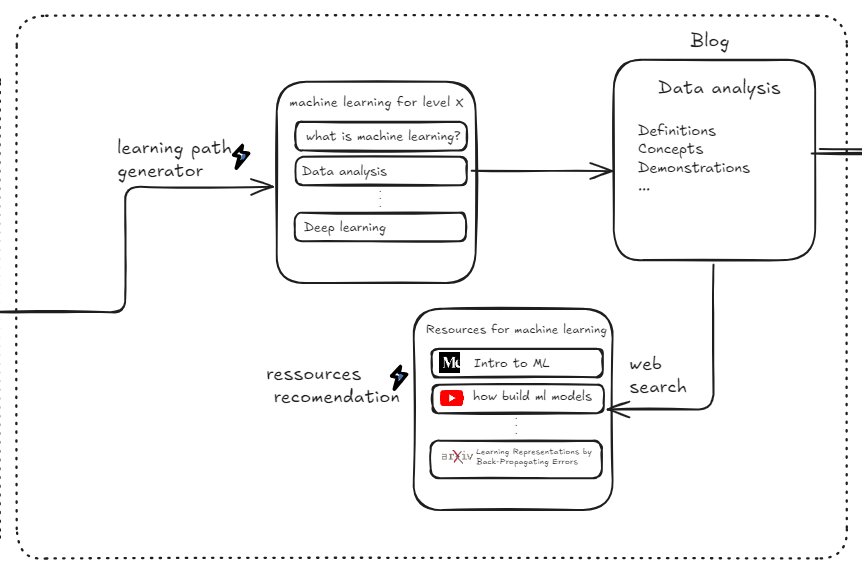

#### LearningPathAgent

In [ ]:
class ModuleContent(BaseModel):
  module_name:str=Field(description="Module Name")
  topics:List[str]=Field(description="List of Topics")
  milestone:str=Field(description="Milestone Description")


class LearningPath(BaseModel):
  student_level:str=Field(description="Student Level")
  course_name:str=Field(description="Course Name")
  learning_path:List[ModuleContent]

class LearningPathInput():
  course_name:str
  level:str
  score:int
  weaknesses:List[str]
  strengths:List[str]

In [ ]:
class LearningPathAgent():
  def __init__(self,model):
    self.__parser=PydanticOutputParser(pydantic_object=LearningPath)
    self.__model=model
    self.__system_prompt='''
    You are an AI-powered learning path generator designed to create personalized learning paths for users based on their level and diagnostic test results. The goal is to provide a structured and effective learning experience tailored to the user's needs.
    Your entire response/output is going to consist of a single JSON object, and you will NOT wrap it within JSON md markers

    ### Input Data
    1. **User Level**: [Beginner, Intermediate, Advanced]
    2. **Diagnostic Test Results**:
      - **Score**: [Score out of 100]
      - **Strengths**: [List of areas where the user performed well]
      - **Weaknesses**: [List of areas where the user needs improvement]
    3. **Course Information**:
      - **Course Name**: [Course Name]

    {format_instructions}
    '''
    self.__user_input="""
    Generate a personalized learning path for a user who is at an {level} level in the course "{course_name}". The user scored {score} on the diagnostic test, with strengths in {strengths}, and weaknesses in {weaknesses}.
    """
    self.__template=ChatPromptTemplate(
        [
            ('system',self.__system_prompt),
            ('human',self.__user_input)
        ],
        input=['level','course_name','score','strengths','weaknesses'],
        partial_variables={"format_instructions": self.__parser.get_format_instructions()}
    )
    self.chain=self.__template|self.__model|self.__parser

  def generate_learning_path(self,learning_path_input:Type[LearningPathInput])->Type[LearningPath]:
    content=self.chain.invoke(
        {
          'level':learning_path_input.level,
          'course_name':learning_path_input.course_name,
          'score':learning_path_input.score ,
          'strengths':learning_path_input.strengths,
          'weaknesses':learning_path_input.weaknesses
        }
    )
    return content

In [ ]:
report_dict = json.loads(report)

In [ ]:
report_dict

{'course_name': 'Machine Learning',
 'level': 'Beginner',
 'score': 46.67,
 'weaknesses': ['Data Preprocessing',
  'Model Selection',
  'Feature Engineering',
  'Model Evaluation',
  'Deep Learning'],
 'strengths': []}

In [ ]:
learning_path=LearningPathInput()
learning_path.course_name=report_dict['course_name']
learning_path.level=report_dict['level']
learning_path.score=report_dict['score']
learning_path.strengths=report_dict['strengths']
learning_path.weaknesses=report_dict['weaknesses']
learning_path

In [ ]:
learning_path_agent=LearningPathAgent(model=model)
learning_path_result=learning_path_agent.generate_learning_path(learning_path)
learning_path_result

LearningPath(student_level='Beginner', course_name='Machine Learning', learning_path=[ModuleContent(module_name='Introduction to Data Preprocessing', topics=['Understanding Data Types', 'Handling Missing Values', 'Data Normalization and Standardization'], milestone='Complete exercises on preprocessing techniques.'), ModuleContent(module_name='Basics of Model Selection', topics=['Understanding Different Types of Models', 'Criteria for Model Selection', 'Train-Test Split'], milestone='Select a model for a small dataset.'), ModuleContent(module_name='Feature Engineering Fundamentals', topics=['Introduction to Features', 'Creating New Features', 'Feature Scaling Techniques'], milestone='Create features for a given dataset.'), ModuleContent(module_name='Model Evaluation Techniques', topics=['Understanding Evaluation Metrics', 'Cross-Validation Techniques', 'Confusion Matrix and ROC Curve'], milestone='Evaluate a model using different metrics.'), ModuleContent(module_name='Introduction to De

#### TopicContentAgent

In [ ]:
class Topic(BaseModel):
  topic_name:str=Field(description='Topic Name')
  explanation:str=Field(description='Detailed Explanation of the Topic')

class TopicContent(BaseModel):
  module_name:str=Field(description='Module Name')
  introduction:str=Field(description='Brief Introduction to the Module')
  topics:List[Topic]

class TopicInput():
  module_name:str
  course_name:str
  topics:List[str]

In [ ]:
class TopicContentAgent():
  def __init__(self,model):
    self.__parser=PydanticOutputParser(pydantic_object=TopicContent)
    self.__model=model
    self.__system_prompt='''
    You're an interactive personal tutor who is an expert at explaining topics. Given a topic and the information to teach, please educate the user about it at a beginner level.
    Your entire response/output is going to consist of a single JSON object.

    ### Input Data
    1. **Module Name**: [Module Name]
    2. **Topics**: [List of Topics]

    {format_instructions}
    '''
    self.__user_prompt='''Generate detailed content for the module {module_name} in the course "{course_name}". The module includes the following topics: {topics}.'''
    self.__template=ChatPromptTemplate(
        [
            ('system',self.__system_prompt),
            ('human',self.__user_prompt)
        ],
        input=['module_name','course_name','topics'],
        partial_variables={"format_instructions": self.__parser.get_format_instructions()}
    )
    self.chain=self.__template|self.__model|self.__parser

  def generate_topic_content(self,topic_input:Type[TopicInput])->Type[TopicContent]:
    content=self.chain.invoke(
        {
          'module_name':topic_input.module_name,
          'course_name':topic_input.course_name,
          'topics':', '.join(topic_input.topics)
        }
    )
    return content

In [ ]:
topic_content_agent=TopicContentAgent(
    model=model
)
topic_content_agent

In [ ]:
learning_path_result.learning_path[0].module_name

'Introduction to Data Preprocessing'

In [ ]:
topic_input=TopicInput()
topic_input.module_name=learning_path_result.learning_path[0].module_name
topic_input.course_name=learning_path_result.course_name
topic_input.topics=learning_path_result.learning_path[0].topics
topic_input

In [ ]:
topic_content_agent.generate_topic_content(topic_input)

TopicContent(module_name='Introduction to Data Preprocessing', introduction='Data preprocessing is a crucial step in the machine learning workflow. It involves cleaning and transforming raw data into a suitable format for analysis. This module will cover various techniques to prepare data effectively, which can significantly improve the performance of machine learning models.', topics=[Topic(topic_name='Understanding Data Types', explanation="Data types represent the kind of data that can be stored in a variable. In machine learning, understanding the various data types is essential because different types require different handling techniques. The primary data types include: 1. **Numerical**: These are numbers and can be further divided into integers (whole numbers) and floats (decimal numbers). 2. **Categorical**: These represent categories or groups, like 'red', 'blue', or 'green'. They can be nominal (no inherent order) or ordinal (with a specific order). 3. **Boolean**: This type 

In [ ]:
api_key = userdata.get('BRAVE_API')

#### Ressources agent

In [ ]:
class ResourceRecommendationAgent():
    def __init__(self, api_key, num_results=3, request_delay=1): # add request_delay parameter
        self.api_key = userdata.get('BRAVE_API')
        self.search = BraveSearch.from_api_key(api_key=api_key, search_kwargs={"count": num_results})
        self.request_delay = request_delay # store request_delay

    def get_link_type(self, link):
        # Simple function to guess the type based on the URL
        if link.endswith('.pdf'):
            return 'PDF'
        elif link.endswith('.jpg') or link.endswith('.png') or link.endswith('.gif'):
            return 'IMAGE'
        else:
            return 'HTML'

    def __call__(self, subject):
        results = self.search.run(subject)
        # Parse the JSON string into a list of dictionaries
        results = json.loads(results)
        output = []
        for res in results:
            if isinstance(res, dict) and 'link' in res:
                link = res['link']
                snippet = res.get('snippet', '')
                title = res.get('title', '')
                link_type = self.get_link_type(link)
                output.append({'title': title, 'link': link, 'snippet': snippet, 'type': link_type})
            elif isinstance(res, str):
                link = res
                link_type = self.get_link_type(link)
                output.append({'link': link, 'type': link_type})
            else:
                # Skip unexpected result formats
                continue
        time.sleep(self.request_delay) # add delay after each request
        return output

In [ ]:
# Example usage:
res_rec_agent = ResourceRecommendationAgent(api_key, num_results=2, request_delay=2)
recommendations = res_rec_agent('machine learning')
print(recommendations)

[{'title': 'Machine learning - Wikipedia', 'link': 'https://en.wikipedia.org/wiki/Machine_learning', 'snippet': '<strong>Machine</strong> <strong>learning</strong> (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can <strong>learn</strong> from data and generalize to unseen data, and thus perform tasks without explicit instructions. Advances in the field of deep <strong>learning</strong> have allowed ...', 'type': 'HTML'}, {'title': 'What Is Machine Learning (ML)? | IBM', 'link': 'https://www.ibm.com/topics/machine-learning', 'snippet': '<strong>Machine</strong> <strong>learning</strong> (ML) is a branch of AI and computer science that focuses on the using data and algorithms to enable AI to imitate the way that humans <strong>learn</strong>.', 'type': 'HTML'}]


In [ ]:
recommendations

[{'title': 'Machine learning - Wikipedia',
  'link': 'https://en.wikipedia.org/wiki/Machine_learning',
  'snippet': '<strong>Machine</strong> <strong>learning</strong> (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can <strong>learn</strong> from data and generalize to unseen data, and thus perform tasks without explicit instructions. Advances in the field of deep <strong>learning</strong> have allowed ...',
  'type': 'HTML'},
 {'title': 'What Is Machine Learning (ML)? | IBM',
  'link': 'https://www.ibm.com/topics/machine-learning',
  'snippet': '<strong>Machine</strong> <strong>learning</strong> (ML) is a branch of AI and computer science that focuses on the using data and algorithms to enable AI to imitate the way that humans <strong>learn</strong>.',
  'type': 'HTML'}]

In [ ]:
# show learning path modules
print(learning_path_result.learning_path)
# Take Module 1  and generate Content
module_1=learning_path_result.learning_path[0]
print(module_1)
# create input of topic agent
topic_input=TopicInput()
topic_input.course_name=learning_path_result.course_name
topic_input.module_name=module_1.module_name
topic_input.topics=module_1.topics
# generate the content of module
module_1_content=topic_content_agent.generate_topic_content(topic_input)
print('\n---------------------------------------------------\n')
print(module_1_content)

[ModuleContent(module_name='Introduction to Data Preprocessing', topics=['Understanding Data Types', 'Handling Missing Values', 'Data Normalization and Standardization'], milestone='Complete exercises on preprocessing techniques.'), ModuleContent(module_name='Basics of Model Selection', topics=['Understanding Different Types of Models', 'Criteria for Model Selection', 'Train-Test Split'], milestone='Select a model for a small dataset.'), ModuleContent(module_name='Feature Engineering Fundamentals', topics=['Introduction to Features', 'Creating New Features', 'Feature Scaling Techniques'], milestone='Create features for a given dataset.'), ModuleContent(module_name='Model Evaluation Techniques', topics=['Understanding Evaluation Metrics', 'Cross-Validation Techniques', 'Confusion Matrix and ROC Curve'], milestone='Evaluate a model using different metrics.'), ModuleContent(module_name='Introduction to Deep Learning', topics=['Basics of Neural Networks', 'Understanding Activation Function

In [ ]:
module_1_content.topics

[Topic(topic_name='Understanding Data Types', explanation='In machine learning, data comes in various forms, known as data types. The most common data types include numerical (which can be further divided into continuous and discrete), categorical (which can be nominal or ordinal), and text data. Understanding these types is important because they determine how we can manipulate and analyze the data. For example, numerical data can be used for mathematical operations, while categorical data often requires encoding techniques to convert it into a numerical format for analysis.'),
 Topic(topic_name='Handling Missing Values', explanation='Missing values are common in datasets and can lead to biased or inaccurate models if not addressed properly. There are several strategies to handle missing values, such as removing rows with missing data, filling in missing values using techniques like mean, median, or mode imputation, or predicting them using models. Choosing the right method depends on

In [ ]:
from pprint import pp
pp(module_1_content.module_name)
pp(module_1_content.introduction)
for topic in module_1_content.topics:
  pp(topic.topic_name)
  pp(topic.explanation)
  # show resources
resources_rec=res_rec_agent(module_1_content.module_name)
pp(resources_rec)

'Introduction to Data Preprocessing'
('Data preprocessing is a crucial step in the machine learning workflow, as it '
 'prepares raw data for modeling by transforming it into a clean and usable '
 'format. This module will cover essential topics that help ensure the quality '
 'and effectiveness of the data used in machine learning algorithms.')
'Understanding Data Types'
('In machine learning, data comes in various forms, known as data types. The '
 'most common data types include numerical (which can be further divided into '
 'continuous and discrete), categorical (which can be nominal or ordinal), and '
 'text data. Understanding these types is important because they determine how '
 'we can manipulate and analyze the data. For example, numerical data can be '
 'used for mathematical operations, while categorical data often requires '
 'encoding techniques to convert it into a numerical format for analysis.')
'Handling Missing Values'
('Missing values are common in datasets and can

### Topic agents

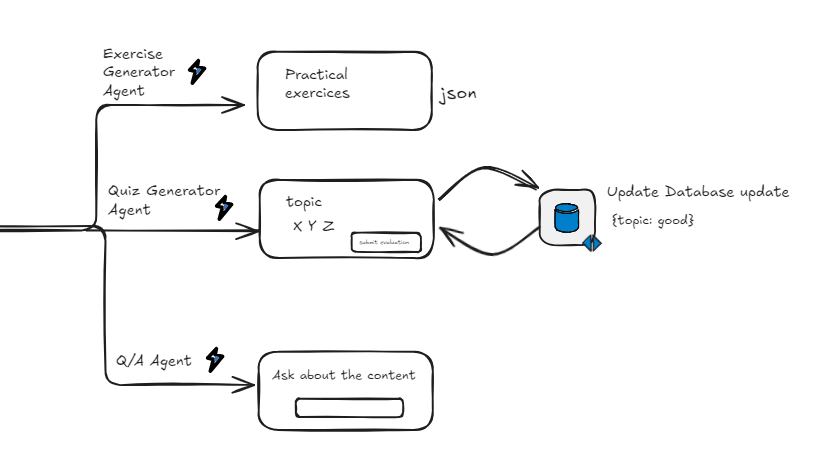

#### Q/A Agent

In [ ]:
class ChatTopicAgent:
    def __init__(self, topics_list, openai_api_key):
        self.topics_list = topics_list
        os.environ["OPENAI_API_KEY"] = openai_api_key

        # Initialize components
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=200
        )
        self.embeddings = OpenAIEmbeddings()

        # Create documents from topics list
        documents = self._create_documents()

        # Create vector store
        self.vector_store = InMemoryVectorStore.from_documents(
            self.text_splitter.split_documents(documents),
            self.embeddings
        )
        self.llm = model

        self.qa_chain = RetrievalQAWithSourcesChain.from_chain_type(
            llm=self.llm,
            chain_type="stuff",
            retriever=self.vector_store.as_retriever(
                search_kwargs={"k": 3}
            )
        )

    def _create_documents(self):
        documents = []
        for topic in self.topics_list:
            # Assuming each topic has 'introduction' and 'module_name'
            documents.append(Document(
                page_content=topic.explanation,
                metadata={"source": topic.topic_name}
            ))
        return documents

    def ask_question(self, question: str) -> dict:
        """Ask a question and return response with RAG details"""
        try:
            result = self.qa_chain({"question": question})

            return {
                "answer": result["answer"],
                "sources": result["sources"],
            }
        except Exception as e:
            return {
                "error": f"An error occurred: {str(e)}",
                "answer": "Could not generate answer",
                "sources": [],
            }

In [ ]:
topic

Topic(topic_name='Data Normalization and Standardization', explanation="Normalization and standardization are techniques used to scale numerical data, ensuring that different features contribute equally to the analysis. Normalization typically rescales the data to a range between 0 and 1, while standardization transforms the data to have a mean of 0 and a standard deviation of 1. This is particularly important for algorithms that rely on distance calculations, such as k-nearest neighbors and gradient descent, as it helps improve the model's performance and convergence speed.")

In [ ]:
agent = ChatTopicAgent(module_1_content.topics, openai_api_key)
response = agent.ask_question("What are the topics I'm reviewing in this module?")

print("\nRetrieved Sources:")
print("Answer:", response["answer"])
print("\nSources:", response["sources"])



Retrieved Sources:
Answer: The topics you are reviewing in this module include:

1. **Data Types**: Understanding different forms of data such as numerical (continuous and discrete), categorical (nominal and ordinal), and text data, and their implications for analysis.

2. **Handling Missing Values**: Strategies for addressing missing data, including removal, imputation techniques (mean, median, mode), and predictive modeling to fill gaps.

3. **Normalization and Standardization**: Techniques for scaling numerical data to ensure features contribute equally to the analysis, which is crucial for certain algorithms.



Sources: Understanding Data Types, Handling Missing Values, Data Normalization and Standardization


#### Exercise Generator

In [ ]:
# Define Exercise Models
class ExerciseBase(BaseModel):
    type: str = Field(description="Type of exercise")

    def display(self):
        raise NotImplementedError

    class Config:
        discriminator = 'type'

class MCQ(ExerciseBase):
    type: str = Field(default="mcq", description="Multiple Choice Question")
    question_text: str = Field(description="MCQ question text")
    options: List[str] = Field(description="List of answer options", min_items=4, max_items=4)
    correct_answer: str = Field(description="Correct option label (e.g., 'A', 'B', 'C', 'D')")

    def display(self):
        print(f"Type: {self.type}")
        print(f"Question: {self.question_text}")
        for idx, option in enumerate(self.options, start=65):  # starts from 'A'
            print(f"{chr(idx)}: {option}")
        print(f"Answer: {self.correct_answer}\n")

class CodeGeneration(ExerciseBase):
    type: str = Field(default="code", description="Code generation exercise")
    question: str = Field(description="Code to be generated or corrected")
    answer: str = Field(description="Correct code")

    def display(self):
        print(f"Type: {self.type}")
        print(f"Question: {self.question}")
        print(f"Answer: {self.answer}\n")

class TheoreticalQuestion(ExerciseBase):
    type: str = Field(default="theoretical", description="Theoretical question")
    question: str = Field(description="Theoretical question")
    answer: str = Field(description="Correct answer explanation")

    def display(self):
        print(f"Type: {self.type}")
        print(f"Question: {self.question}")
        print(f"Answer: {self.answer}\n")

# ExerciseList Model
class ExerciseList(BaseModel):
    exercises: List[Union[MCQ, CodeGeneration, TheoreticalQuestion]]

    @root_validator(pre=True)
    def log_parsed_exercises(cls, values):
        for exercise in values.get("exercises", []):
            print(f"Parsing exercise with type: {exercise.get('type')}")
        return values

# ExerciseGenerator Class
class ExerciseGenerator:
    def __init__(self, model, topics: List[Topic], num_exercises: int = 5):
        self.model = model
        self.topics = topics
        self.num_exercises = num_exercises
        self.parser = PydanticOutputParser(pydantic_object=ExerciseList)

        self.system_prompt = '''
        You are an exercise generator for a course module.
        Given a topic name and explanation, generate {num_exercises} exercises.
        The exercises should be diverse in type, including code generation, MCQ, and theoretical questions.
        For MCQs, provide a question text, four answer options labeled A, B, C, D, and indicate the correct answer.
        Your response should be a JSON object with a key "exercises" containing a list of exercises.
        Each exercise should have a "type" field and corresponding fields based on the type:
        - For "mcq": "question_text", "options" (list of 4 strings), "correct_answer" (one of "A", "B", "C", "D")
        - For "code": "question", "answer"
        - For "theoretical": "question", "answer"

        {format_instructions}
        '''

        self.user_prompt = '''
        Generate {num_exercises} exercises for the topic "{topic_name}".
        Use the explanation: {explanation} to create relevant questions.
        '''

        self.template = ChatPromptTemplate(
            messages=[
                ('system', self.system_prompt),
                ('human', self.user_prompt)
            ],
            input_variables=['topic_name', 'explanation', 'num_exercises'],
            partial_variables={
                "format_instructions": self.parser.get_format_instructions()
            }
        )

        self.chain = self.template | self.model | self.parser

    def generate_exercises(self) -> List[ExerciseBase]:
        all_exercises = []
        for topic in self.topics:
            try:
                response = self.chain.invoke({
                    'topic_name': topic.topic_name,
                    'explanation': topic.explanation,
                    'num_exercises': self.num_exercises
                })
                exercises = response.exercises
                all_exercises.extend(exercises)
            except Exception as e:
                print(f"Error generating exercises for topic {topic.topic_name}: {e}")
        return all_exercises

<ipython-input-241-604c63b76593>:48: PydanticDeprecatedSince20: Pydantic V1 style `@root_validator` validators are deprecated. You should migrate to Pydantic V2 style `@model_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.9/migration/
  @root_validator(pre=True)


In [ ]:
module_1_content.topics

[Topic(topic_name='Understanding Data Types', explanation='In machine learning, data comes in various forms, known as data types. The most common data types include numerical (which can be further divided into continuous and discrete), categorical (which can be nominal or ordinal), and text data. Understanding these types is important because they determine how we can manipulate and analyze the data. For example, numerical data can be used for mathematical operations, while categorical data often requires encoding techniques to convert it into a numerical format for analysis.'),
 Topic(topic_name='Handling Missing Values', explanation='Missing values are common in datasets and can lead to biased or inaccurate models if not addressed properly. There are several strategies to handle missing values, such as removing rows with missing data, filling in missing values using techniques like mean, median, or mode imputation, or predicting them using models. Choosing the right method depends on

In [ ]:
# Assuming `model` is defined elsewhere
exercise_generator = ExerciseGenerator(model=model, topics=module_1_content.topics, num_exercises=2)
exercises = exercise_generator.generate_exercises()

# Display generated exercises
for exercise in exercises:
    exercise.display()

Parsing exercise with type: mcq
Parsing exercise with type: theoretical
Parsing exercise with type: mcq
Parsing exercise with type: theoretical
Parsing exercise with type: mcq
Parsing exercise with type: theoretical
Type: mcq
Question: Which of the following data types can be further divided into continuous and discrete?
A: A. Categorical
B: B. Text
C: C. Numerical
D: D. Ordinal
Answer: C

Type: theoretical
Question: Explain why understanding data types is crucial in machine learning.
Answer: Understanding data types is crucial in machine learning because they dictate how data can be manipulated and analyzed. Numerical data allows for mathematical operations such as addition and averaging, while categorical data often requires encoding techniques to convert it into a numerical format for analysis. This understanding helps in selecting appropriate algorithms and preprocessing techniques, ensuring the model can effectively learn from the data.

Type: mcq
Question: What is one common meth

#### Quiz Generator Agent

In [ ]:
# Define the models for the quiz question and content
class QuizQuestion(BaseModel):
    question: str = Field(description='The quiz question')
    options: List[str] = Field(description='List of multiple-choice options')
    correct_answers: List[str] = Field(description='List of correct answers (can have multiple)')

class QuizContent(BaseModel):
    module_name: str = Field(description='Module Name')
    questions: List[QuizQuestion] = Field(description='List of quiz questions')

# Define the quiz input model with number of questions as an input
class QuizInput(BaseModel):
    module_name: str
    course_name: str
    topics: List[str]
    num_questions: int

# Define the QuizContentAgent class
class QuizContentAgent():
    def __init__(self, model):
        self.__parser = PydanticOutputParser(pydantic_object=QuizContent)
        self.__model = model
        self.__system_prompt = '''
        You are a quiz generator based on the topics provided. For each topic, create a set of {num_questions} quiz questions with multiple-choice options.
        The output should contain {num_questions} questions for each topic along with their options and the correct answers. Ensure each question has at least one correct answer and that all answers are included.

        ### Input Data
        1. **Module Name**: [Module Name]
        2. **Topics**: [List of Topics]
        3. **Number of Questions**: [num_questions]

        {format_instructions}

        ### Expected Output:
        The result should be a JSON object that contains the following keys:
        - "module_name": The module's name.
        - "questions": An array of {num_questions} question objects. Each question should have:
            - "question": The question text.
            - "options": An array of multiple-choice options.
            - "correct_answers": An array of correct answers (Its very very important to have at least one correct answer).

        Ensure the JSON is valid and complete. Do not include any extra text.
        '''

        self.__user_prompt = '''
        Generate {num_questions} quiz questions for the module {module_name} in the course "{course_name}".
        The module includes the following topics: {topics}.
        Please provide {num_questions} questions for each topic with multiple-choice options. Some questions may have more than one correct answer, so list all correct answers accordingly.

        The output should be a valid JSON object with the following fields:
        - "module_name": The module's name.
        - "questions": An array of {num_questions} questions, each having:
            - "question": The question text.
            - "options": Multiple-choice options.
            - "correct_answers": A list of correct answers for each question.
        '''

        self.__template = ChatPromptTemplate(
            [
                ('system', self.__system_prompt),
                ('human', self.__user_prompt)
            ],
            input=['module_name', 'course_name', 'topics', 'num_questions'],
            partial_variables={"format_instructions": self.__parser.get_format_instructions()}
        )

        self.chain = self.__template | self.__model | self.__parser

    def generate_quiz_content(self, quiz_input: QuizInput) -> QuizContent:
        content = self.chain.invoke(
            {
                'module_name': quiz_input.module_name,
                'course_name': quiz_input.course_name,
                'topics': ', '.join(quiz_input.topics),
                'num_questions': quiz_input.num_questions * len(quiz_input.topics)
            }
        )
        return content

In [ ]:
learning_path_result

LearningPath(student_level='Beginner', course_name='Machine Learning', learning_path=[ModuleContent(module_name='Introduction to Data Preprocessing', topics=['Understanding Data Types', 'Handling Missing Values', 'Data Normalization and Standardization'], milestone='Complete exercises on preprocessing techniques.'), ModuleContent(module_name='Basics of Model Selection', topics=['Understanding Different Types of Models', 'Criteria for Model Selection', 'Train-Test Split'], milestone='Select a model for a small dataset.'), ModuleContent(module_name='Feature Engineering Fundamentals', topics=['Introduction to Features', 'Creating New Features', 'Feature Scaling Techniques'], milestone='Create features for a given dataset.'), ModuleContent(module_name='Model Evaluation Techniques', topics=['Understanding Evaluation Metrics', 'Cross-Validation Techniques', 'Confusion Matrix and ROC Curve'], milestone='Evaluate a model using different metrics.'), ModuleContent(module_name='Introduction to De

In [ ]:
quiz_content_agent = QuizContentAgent(model=model)

# Generate quiz content and structure the data
learning_path_data = {
    "student_level": learning_path_result.student_level,
    "course_name": learning_path_result.course_name,
    "learning_path": []
}

# Loop through the LearningPath and generate quizzes for each module
for module in learning_path_result.learning_path:
    quiz_input = QuizInput(
        module_name=module.module_name,
        course_name=learning_path_result.course_name,
        topics=module.topics,
        num_questions=5
    )

    # Generate quiz content for the current module
    quiz_content = quiz_content_agent.generate_quiz_content(quiz_input)

    if quiz_content:
        module_data = {
            "module_name": module.module_name,
            "milestone": module.milestone,
            "topics": module.topics,
            "quiz": {
                "num_questions": quiz_input.num_questions * len(quiz_input.topics),
                "questions": []
            }
        }

        # Adding the quiz questions to the module data
        for question in quiz_content.questions:
            module_data["quiz"]["questions"].append({
                "question": question.question,
                "options": question.options,
                "correct_answers": question.correct_answers
            })

        # Append the module data to the learning path
        learning_path_data["learning_path"].append(module_data)
    else:
        print(f"Error generating quiz content for module: {module.module_name}")

# Convert the learning path data to JSON
learning_path_json = json.dumps(learning_path_data, indent=2)

print(learning_path_json)

{
  "student_level": "Beginner",
  "course_name": "Machine Learning",
  "learning_path": [
    {
      "module_name": "Introduction to Data Preprocessing",
      "milestone": "Complete exercises on preprocessing techniques.",
      "topics": [
        "Understanding Data Types",
        "Handling Missing Values",
        "Data Normalization and Standardization"
      ],
      "quiz": {
        "num_questions": 15,
        "questions": [
          {
            "question": "What are the common data types in machine learning?",
            "options": [
              "Integer",
              "String",
              "Float",
              "Boolean"
            ],
            "correct_answers": [
              "Integer",
              "String",
              "Float",
              "Boolean"
            ]
          },
          {
            "question": "Which of the following is not a data type?",
            "options": [
              "Object",
              "List",
              "Tuple",


Creating a logic to grade the Quiz

In [ ]:
user_answers = {
    "Introduction to Machine Learning": [
        {
            "question": "What is Machine Learning?",
            "user_answers": ["A subset of Artificial Intelligence"],
            "correct_answers": ["A subset of DL"]
        },
        {
            "question": "What are the types of Machine Learning?",
            "user_answers": ["Supervised Learning", "Unsupervised Learning", "Reinforcement Learning"],
            "correct_answers": ["Supervised Learning", "Unsupervised Learning", "Reinforcement Learning"]
        },
        {
            "question": "What is the main application of Machine Learning?",
            "user_answers": ["Image recognition", "Predictive analytics"],
            "correct_answers": ["Image recognition", "Predictive analytics"]
        },
        {
            "question": "Which of the following is a method in Supervised Learning?",
            "user_answers": ["Linear Regression"],
            "correct_answers": ["Linear Regression"]
        },
        {
            "question": "Which is a common algorithm used in Machine Learning?",
            "user_answers": ["Decision Trees", "K-Means"],
            "correct_answers": ["Decision Trees", "K-Means"]
        }
    ],
    "Statistics Fundamentals": [
        {
            "question": "What is Descriptive Statistics?",
            "user_answers": ["Summarizing data"],
            "correct_answers": ["Summarizing data"]
        },
        {
            "question": "What is Inferential Statistics?",
            "user_answers": ["Drawing conclusions from data"],
            "correct_answers": ["Drawing conclusions from data"]
        },
        {
            "question": "What is Probability Theory?",
            "user_answers": ["Understanding random events"],
            "correct_answers": ["Understanding random events"]
        },
        {
            "question": "What is the main use of Probability in Machine Learning?",
            "user_answers": ["Modeling uncertainty"],
            "correct_answers": ["Modeling uncertainty"]
        },
        {
            "question": "Which of the following is an example of Inferential Statistics?",
            "user_answers": ["Hypothesis Testing"],
            "correct_answers": ["Hypothesis Testing"]
        }
    ]
}


In [ ]:
def calculate_module_score(module_name, user_answers):
    # Get answers for this module
    module_answers = user_answers.get(module_name, [])
    correct_answers = 0
    total_questions = len(module_answers)

    for answer in module_answers:
        # Compare user answers to the correct answers
        user_answer_set = set(answer['user_answers'])
        correct_answer_set = set(answer['correct_answers'])

        # If the user answers match the correct answers, count as correct
        if user_answer_set == correct_answer_set:
            correct_answers += 1

    # Calculate the module score as percentage
    module_score = (correct_answers / total_questions) * 100 if total_questions > 0 else 0
    return module_score


def calculate_overall_score(user_answers):
    total_correct = 0
    total_questions = 0
    module_scores = {}

    # Loop through each module to calculate the module score
    for module_name in user_answers:
        module_score = calculate_module_score(module_name, user_answers)
        module_scores[module_name] = module_score
        total_correct += (module_score / 100) * len(user_answers[module_name])
        total_questions += len(user_answers[module_name])

    # Calculate overall score as a percentage
    overall_score = (total_correct / total_questions) * 100 if total_questions > 0 else 0
    return overall_score, module_scores

# Example usage
overall_score, module_scores = calculate_overall_score(user_answers)

print(f"Final Quiz Score: {overall_score}%")
for module, score in module_scores.items():
    print(f"Score for {module}: {score}%")


Final Quiz Score: 90.0%
Score for Introduction to Machine Learning: 80.0%
Score for Statistics Fundamentals: 100.0%
